# Predicting Heart Disease With Age, Serum Cholesterol, Resting Blood Pressure and Maximum Heart Rate Using KNN Classification Method


# Introduction
Heart disease refers to several types of heart conditions, which is the main cause of death in the USA for most racial and ethnic groups (1). The main heart disease risk factors are high blood pressure, high blood cholesterol, smoking, and age(2). Some of the common heart disease symptoms are chest pain, irregular heartbeats (heartbeats too fast or too slow or irregularly), Pain in the back, and shortness of breath (2). A doctor usually diagnoses patients as either healthy or having a heart disease based on their risk factors and symptoms. As a result, a doctor may predict heart disease based on the current situation and past experiments. The original Heart disease data for four different regions (Cleveland, Hungarian, Switzerland and  Long Beach VA) was read from the main link (found on the Kaggle website) to be used for predicting heart disease (3). This dataset contains 11 variables; however, Age, RestingBP, Cholesterol, and MaxHR variables will be used to predict the heart disease status (1 = heart disease and 0 = normal). We will intend to design a model using a knn classification method in which the heart disease status (1 = heart disease and 0 = normal) will be predictd based on the following numerical variables:  
Age, resting blood pressure (mmHg), maximum heart rate, and serum cholesterol level (mm/dl).

#### Question: 
Can we use the age, normal blood pressure when the body is at rest, maximum heart rate achieved, and blood cholesterol level variables to predict if the patient has heart disease?  

# Methods and Results

In [65]:
### Loading Libraries into R
library(tidyverse)
library(tidymodels)
library(cowplot)
library(repr)
options(repr.matrix.max.rows = 6)

#set the seed
set.seed(123) 

The data for the column `HeartDisease` is filtered for only 0 (normal) and 1 (heart-disease) because this column had other subclasses for the heart disease but they are a negligible minority in the data (~100 observation); however, the focus of this model is on two main classes of “normal” and “diseased” 

In [66]:
url1<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
url2<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
url3<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"
url4<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"

data1 <- read_csv(url1, col_names=FALSE)
data2 <- read_csv(url2, col_names=FALSE)
data3 <- read_csv(url3, col_names=FALSE)
data4 <- read_csv(url4, col_names=FALSE)

heart_data <- rbind(data1, data2, data3, data4) |>
    select (X1:X10, X14) |>
    filter (X14 == 0 | X14 == 1) |>
    rename (Age = X1, Sex = X2, 
           ChestPainType = X3,RestingBP = X4, 
           Cholesterol = X5, FastingBS = X6,
           RestingECG= X7, MaxHR = X8,
           ExerciseAngina = X9, Oldpeak = X10, HeartDisease = X14) 

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

### Variable Explanation 

`Age`: age of the patient [years]

`RestingBP`: resting blood pressure [mm Hg]

`Cholesterol`: serum cholesterol [mm/dl]

`MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]

`HeartDisease`:[1: heart disease, 0: Normal]

### Wrangling & Cleaning the Data
The data is tibble but it needs to be cleaned as some of the variables variables contain missing data. The `Cholesterol`, `RestingBP` and `MaxHR` = ? or 0 which is equivalent to NA in this data set. 

In [76]:
heart_data1 <- heart_data|>
        filter(Cholesterol=="?" | Cholesterol== 0)|>
        group_by(Cholesterol)|>
        summarize(n=n())

heart_data2 <- heart_data|>
        filter(Age=="?" | Age == 0)|>
        group_by(Age)|>
        summarize(n=n())

heart_data3 <- heart_data|>
        filter(RestingBP=="?" | RestingBP == 0)|>
        group_by(RestingBP)|>
        summarize(n=n())

heart_data4 <- heart_data|>
        filter(MaxHR=="?" | MaxHR == 0)|>
        group_by(MaxHR)|>
        summarize(n=n())


In [83]:
print("Table 1. Number of missing data for the cholestrol variable")
heart_data1
print("Table 2. Number of missing data for the age variable")
heart_data2
print("Table 3. Number of missing data for the resting blood pressure variable")
heart_data3
print("Table 4. Number of missing data for the max heart rate achieved variable")
heart_data4



[1] "Table 1. Number of missing data for the cholestrol variable"


Cholesterol,n
<chr>,<int>
?,26
0,82


[1] "Table 2. Number of missing data for the age variable"


Age,n
<dbl>,<int>


[1] "Table 3. Number of missing data for the resting blood pressure variable"


RestingBP,n
<chr>,<int>
?,33


[1] "Table 4. Number of missing data for the max heart rate achieved variable"


MaxHR,n
<chr>,<int>
?,33


Table 2 suggests that column `Age` has no missing data. Furthermore, Table 1, 3 and 4 indicate that blood cholesterol data of 108 (82 + 26) patients, resting blood pressure of 33 patients, and maximum heart rate achieved of 33 patients are missing; so, the data set is filtered to remove `Cholesterol`,`RestingBP` and `MaxHR` = ? or 0. Therefore, the filter() function will be used to eliminate those variables that do not contain observation.

In [79]:
#We filter against 0 and ? in Cholesterol and against ? in RestingBP and MaxHR
heartdisease_data <- heart_data|> 
    filter(Cholesterol!= "?", RestingBP != "?", MaxHR!= "?") |>
    filter(Cholesterol!= 0)

In the above data set `HeartDisease` was incorrectly stored as a numerical (dbl) column; therefore, we will use mutate() function to turn it into a factor. Moreover, the following variables (`Age`, `RestingBP`, `Cholesterol` and `MaxHR`) were incorrectly stored as characteristic; therefore, we also will use mutate() function to turn it into numeric data. Then the select() function is used to select these variables as predictors in this model. 

In [108]:
#Convert the character class variable to the factor data type
data_heart <- heartdisease_data|>
        mutate(HeartDisease = as.factor(HeartDisease))|>
        mutate(RestingBP = as.numeric(RestingBP)) |>
        mutate(Cholesterol = as.numeric(Cholesterol)) |>
        mutate(MaxHR = as.numeric(MaxHR)) |>
        select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease)
print("Table 5. Summary of the Data Set for the Planned Analysis")
data_heart

[1] "Table 5. Summary of the Data Set for the Planned Analysis"


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,132,185,0
29,120,243,160,0
30,170,237,170,0
⋮,⋮,⋮,⋮,⋮
62,158,170,138,1
54,127,333,154,1
62,120,254,93,1


### Splitting the Data
Splitting the data into a training set and testing set using 75% of the data for training. We are splitting the data into training and testing sets in order to evaluate our model prediction accuracy.

In [81]:
set.seed(123)
heart_split <- initial_split(data_heart, prop = 0.75, strata = HeartDisease) 
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

Finding the ratio of each class of the target variable (0 = Normal, 1 = Diseased) in the training data.

In [109]:
n_row_train <- nrow(heart_train)
data_train_percentage <- heart_train |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row_train*100)
print("Table 6. Ratio and number of each class of the target variable (0 = Normal, 1 = Diseased) in the training data")
data_train_percentage

[1] "Table 6. Ratio and number of each class of the target variable (0 = Normal, 1 = Diseased) in the training data"


HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,267,65.60197
1,140,34.39803


Table 6 suggests the distribution of the target variable classes 0 (normal, 65.6%) and 1 (heart-disease, 34.4%) are not even. In other words, more of the observations are normal, and a smaller portion is heart-diseased patients. This uneven distribution of target variable classes suggests that the dataset is influenced by one of the classes, and it may affect the accuracy of the model with biased predictions.

### Explatory Data Analysis 

Table summary of the predictors and their numerical distribution (mean and variance) in each class of the target variable (0 = Normal, 1 = Diseased)

In [110]:
nheart <- heart_train |>
        group_by(HeartDisease)|>
        summarize(Observation=n())

table_7 <- heart_train|>
    group_by(HeartDisease)|>
    summarize(across(Age:MaxHR, mean, na.rm=TRUE)) 
mean_heart_disease <- merge(table_7,nheart) |>
    rename(Avg_Age = Age, Avg_RestingBP = RestingBP, Avg_Cholesterol = Cholesterol, Avg_MaxHR = MaxHR)
print("Table 7. Averages of the predictor variables in the training set")
mean_heart_disease

[1] "Table 7. Averages of the predictor variables in the training set"


HeartDisease,Avg_Age,Avg_RestingBP,Avg_Cholesterol,Avg_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,50.05993,129.1273,242.6854,148.9363,267
1,52.36429,135.8643,261.9643,134.3786,140


In [111]:
table_8 <- heart_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, var, na.rm=TRUE)) 
variance_heart_disease <- merge(table_8,nheart) |>
    rename(var_Age = Age, var_RestingBP = RestingBP, var_Cholesterol = Cholesterol, var_MaxHR = MaxHR) 
print("Table 8. Variance of the predictor variables in the training set ")
variance_heart_disease

[1] "Table 8. Variance of the predictor variables in the training set "


HeartDisease,var_Age,var_RestingBP,var_Cholesterol,var_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,82.08662,272.6830,3434.126,584.1651,267
1,63.21166,344.5786,4839.215,520.9132,140


Based on tables 7 and 8, the Mean and variance of the variables that we want to use as predictors are not in a similar range. As a result, we need to standardize the data by scaling and centring the variables to have comparable predictors.

In [89]:
set.seed(123)
data_train_recipe <- recipe(HeartDisease ~ ., data= heart_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors()) |>
    prep()

scaled_heart <- bake(data_train_recipe, heart_train)

The standardized training data is visualized in the form of scatter plots in order to find any potential correlation between predictors and their effect on the classification of the target variables. 

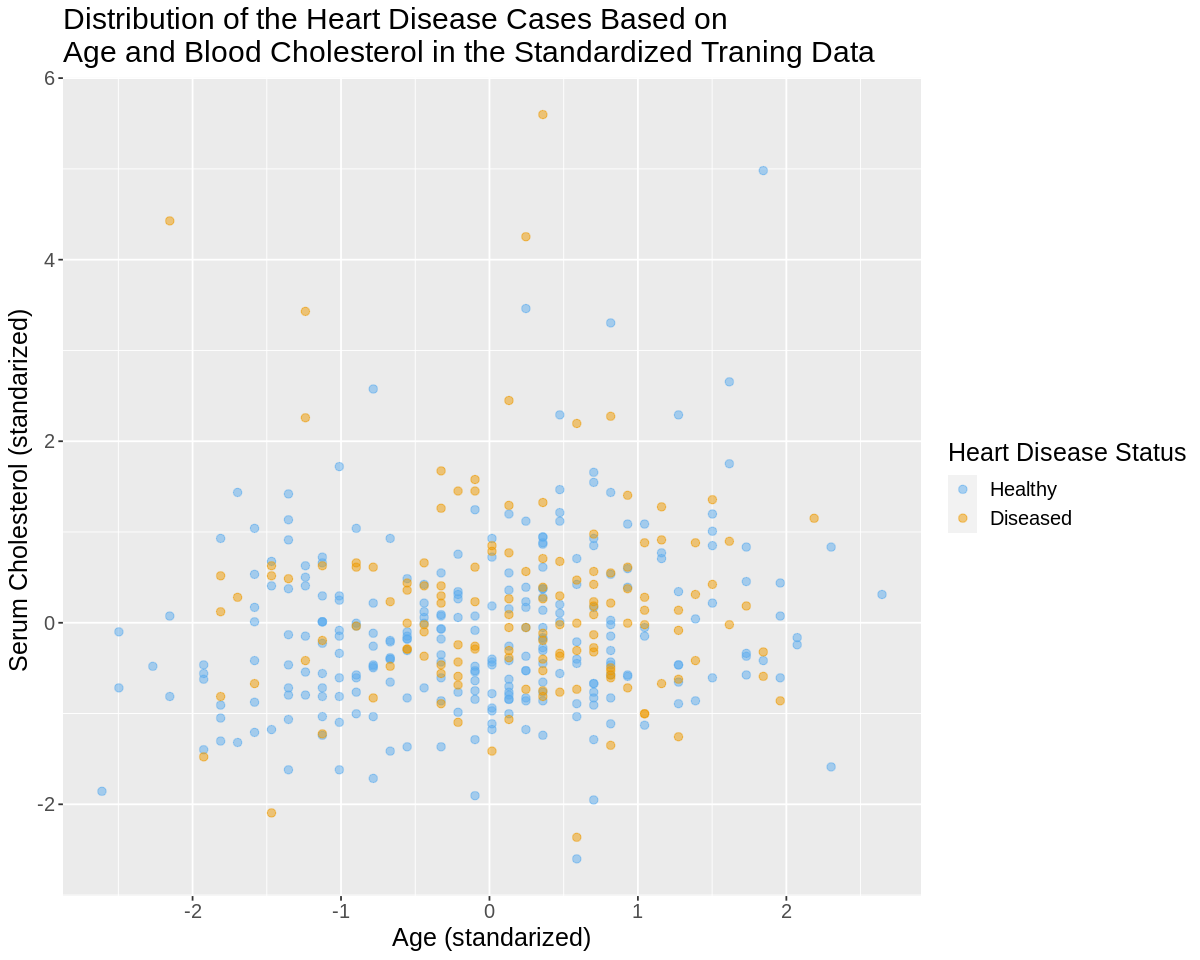

In [90]:
options(repr.plot.width = 10, repr.plot.height = 8) 

#scaterplot resting blood pressure and age 
agevsbp <- ggplot(scaled_heart, aes(x = Age, y = Cholesterol, color = HeartDisease)) +
      geom_point( alpha = 0.5, size = 2) +
      xlab("Age (standarized)") +
      ylab("Serum Cholesterol (standarized) ") +
        labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 15),
        legend.position = "right",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Healthy","Diseased"),
                           values= c("steelblue2","orange2"))+
        ggtitle("Distribution of the Heart Disease Cases Based on \nAge and Blood Cholesterol in the Standardized Traning Data") 
 agevsbp     

Figure 1: Scatter plot of Serum Cholesterol versus Age, colored by heart disease status label

Figure 1 suggests that there is no obvious correlation between age and serum cholesterol. However, the figure shows that most heart-diseased patients are at the higher end of the age axis. Surprisingly, the distribution of the ‘healthy’ and ‘diseased’ observations does not seem to be dependent on the serum cholesterol level since no pattern is seen as the cholesterol level increases. 

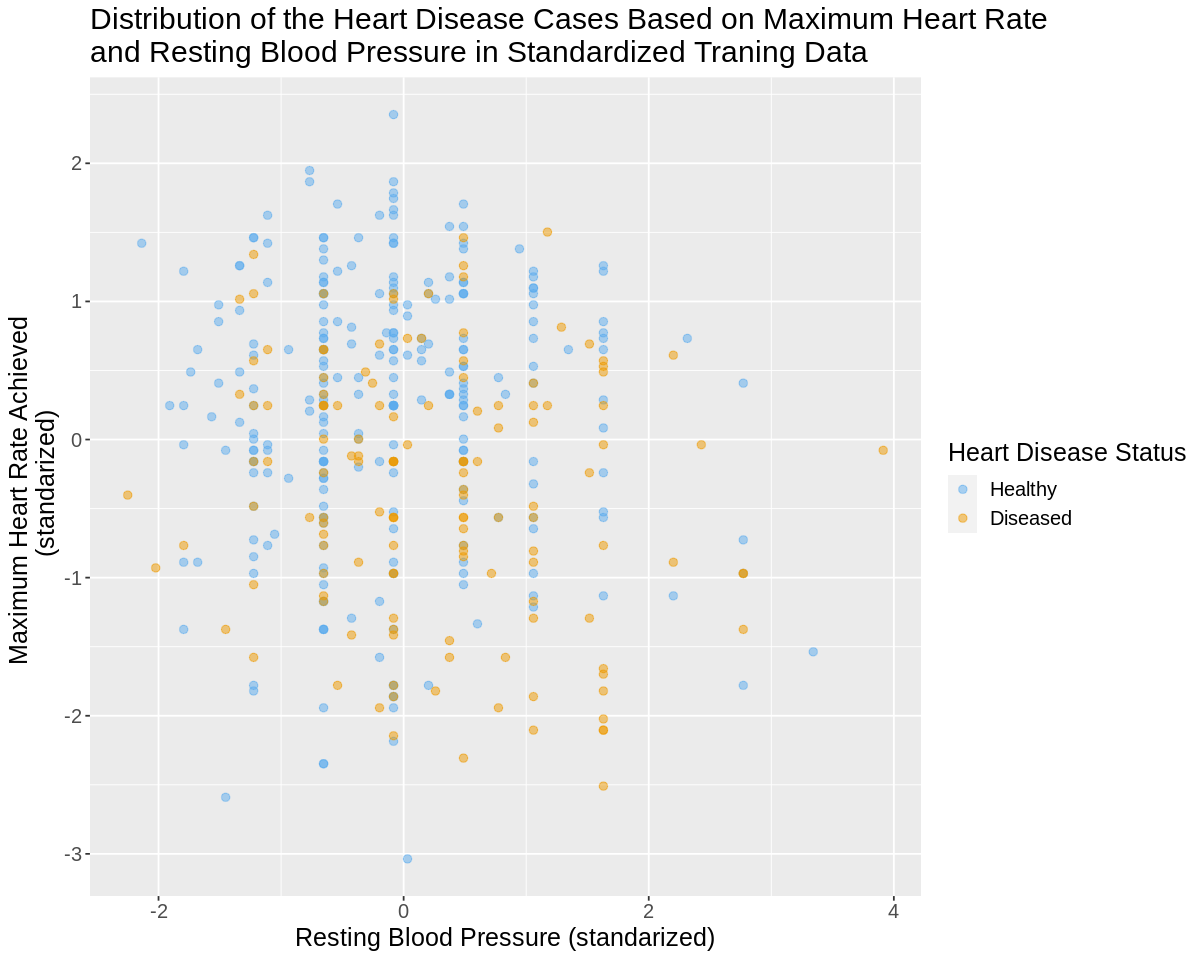

In [91]:
options(repr.plot.width = 10, repr.plot.height = 8) 
cholvshr <- ggplot(scaled_heart, aes(x = RestingBP, y = MaxHR, color = HeartDisease)) +
      geom_point(alpha = 0.5, size = 2) +
      xlab("Resting Blood Pressure (standarized)") +
      ylab("Maximum Heart Rate Achieved \n (standarized)") +
      labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 15),
        legend.position = "right",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Healthy","Diseased"),
                           values= c("steelblue2","orange2"))+
        ggtitle("Distribution of the Heart Disease Cases Based on Maximum Heart Rate \nand Resting Blood Pressure in Standardized Traning Data")
cholvshr

Figure 2: Scatter plot of maximum heart rate achieved versus resting blood pressure,  colored by heart disease status label

In figure 2, resting blood pressure does not correlate with the maximum heart rate achieved. However, the figure suggests that as the maximum heart rate achieved increases, the observation of ‘healthy’ also increases. In contrast, the distribution of the healthy and heart-diseased patients seems to be not correlated with resting blood pressure.

### Determining the best k value (number of neighbors)

Now, we want to find the K (neighbour) value that gives the highest accuracy of the model in our training set.
In order to achieve that, we will analyze the K from 1 – 100 to analyze a wide range of possible values for K. However, because it takes a lot of time to find the accuracy for every single K, we decided to analyze K values in 5-unit intervals (by = 5).
Also, we will perform a 10-fold cross-validation on our training set.

In [93]:
set.seed(123)
print ("Table 9. The nubmer of neighbors (K-value) wiht the highest accuracy")
data_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

k_vals <- tibble(neighbors= seq(from= 1, to= 100, by= 5))

knn_result <- workflow()|>
    add_recipe(data_train_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples=data_vfold, grid=k_vals)|>
    collect_metrics()

accuracies <- knn_result |>
  filter(.metric == "accuracy")

maxmax<- accuracies|>
    filter(mean == max(mean))
maxmax

[1] "Table 8. The nubmer of neighbors (K-value) wiht the highest accuracy"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
46,accuracy,binary,0.6931098,10,0.01722591,Preprocessor1_Model10
51,accuracy,binary,0.6931098,10,0.01947809,Preprocessor1_Model11


Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


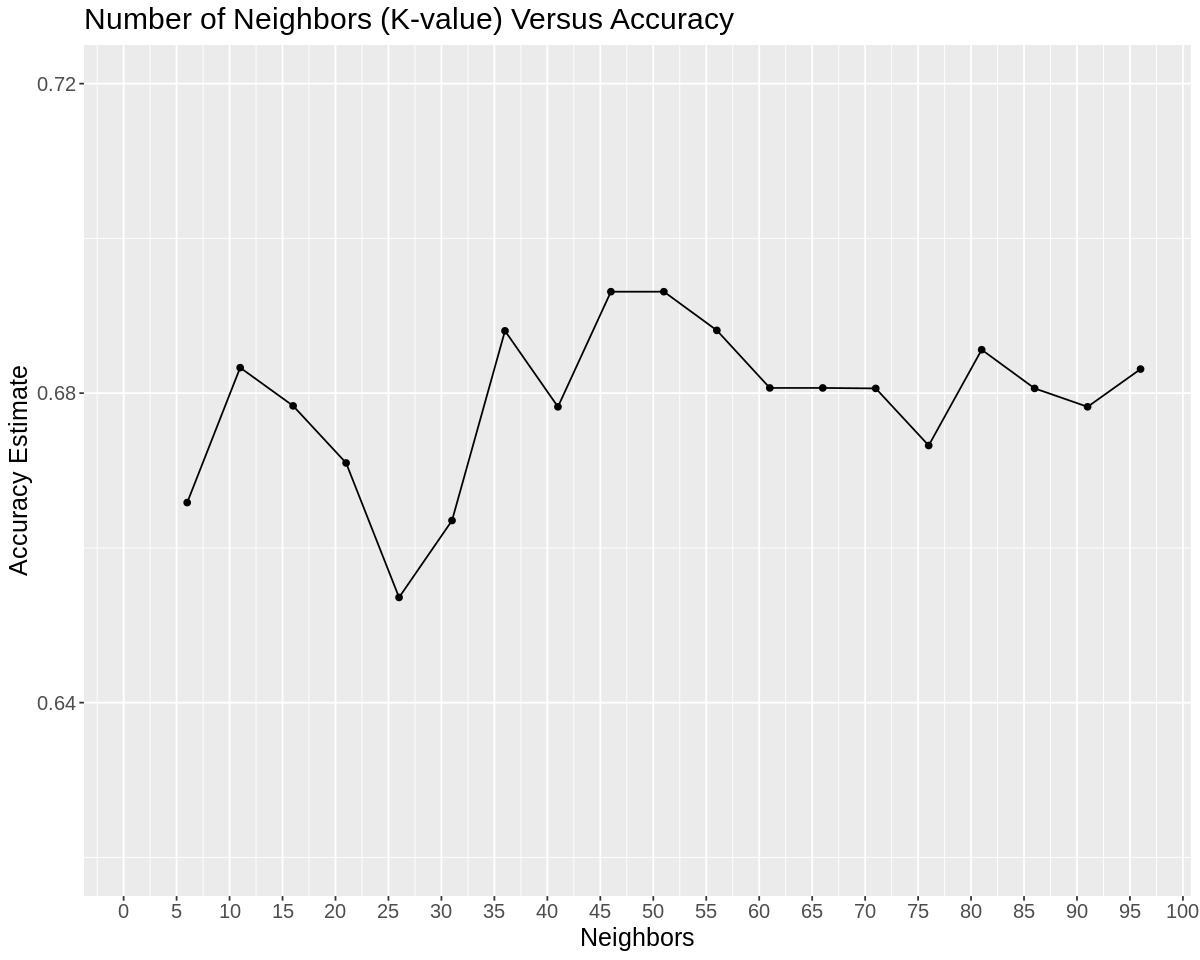

In [94]:
accuracy_vs_k <- ggplot(accuracies, aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 15))+
    scale_x_continuous(breaks = seq(0, 100, by = 5))+  
    scale_y_continuous(limits = c(0.62, 0.72), breaks=seq(0.6, 1, by=0.04))+
    ggtitle ("Number of Neighbors (K-value) Versus Accuracy")
accuracy_vs_k

Figure 3: Plot of estimated accuracy versus the number of neighbors (K-value)

Based on the information in table 9 and figure 3, setting the number of neighbours to K = 46 and K = 51 give the highest accuracy (69.31%). Figure 3 shows values after k = 30 have similar accuracy. Therefore, any selection from k= 35 to k= 95 can be reasonable, but k = 46 or 55 provides the highest accuracy, and Table 5 also approves this result. Therefore, between these two k values which give the highest accuracy in the training data, we will use k = 46 arbitrarily.

Then K = 46 will be used to test the accuracy of our model in the testing data. Then K-nearest neighbours classifier will be compared with the majority classifier from the original data set (data_heart).

In [97]:
set.seed(123)

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 46) |>
       set_engine("kknn") |>
       set_mode("classification")

mnist_fit <- workflow() |>
            add_recipe(data_train_recipe) |>
            add_model(mnist_spec) |>
            fit(data = heart_train)

mnist_predictions <- predict(mnist_fit, heart_test)|>
        bind_cols(heart_test)

mnist_metrics <- mnist_predictions |>
        metrics(truth=HeartDisease, estimate = .pred_class) |>
        filter(.metric=="accuracy")|>
        select(.metric, .estimate)
print("Table 10. The model accuracy estimate for testing data")
mnist_metrics

[1] "Table 9. The model accuracy estimate for testing data"


.metric,.estimate
<chr>,<dbl>
accuracy,0.6911765


In [98]:
set.seed (123)
n_row <- nrow(data_heart)

data_percentage <- data_heart |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row*100)
print("Table 11. Ratio and number of each class of the target variable (0 = Normal, 1 = Diseased) in the data set")
data_percentage

[1] "Table 10. Ratio and number of each class of the target variable (0 = Normal, 1 = Diseased) in the data set"


HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,356,65.56169
1,187,34.43831


Comparing tables 10 and 11, model prediction accuracy (69%) is slightly greater than the majority proportion (65%). This could suggest that our model does not have much more strength in predicting heart disease because the difference between the K-nearest neighbours classifier will be compared with the majority classifier from the original data set is only 4%. 

In addition, for the prediction of heart disease, the accuracy of 69% could be a better value. Heart disease is a severe disease that causes a lot of death yearly, so the accuracy for the prediction of this data should be higher to be applied. Therefore, this result suggests that prediction with the used predictor variables is insufficient; however, it is also important to check the confusion matrix. 

In [99]:
mnist_conf_mat <- mnist_predictions |>
        conf_mat(truth = HeartDisease, estimate = .pred_class)
print("Table 12. Confusion matrix of heart disease prediction")
mnist_conf_mat

[1] "Table 8. Confusion matrix of heart disease prediction"


          Truth
Prediction  0  1
         0 82 35
         1  7 12

The confusion matrix (table 12) displays 82 observations were correctly predicted as healthy, and 12 were correctly predicted as diseased. However, it shows 35 patients as healthy while having heart disease, and 7 patients were predicted to have heart disease while they were healthy. Therefore, the classifier predicts 94 (82 + 12) observations correctly, and it determines 42 (35 + 7) observations incorrectly. As a result, this confusion matrix suggests that this prediction is not helpful as many patients (35) with heart disease were misdiagnosed as healthy, and they may not receive further tests and treatments, which is dangerous.

## Colored Prediction Map Visualizations 

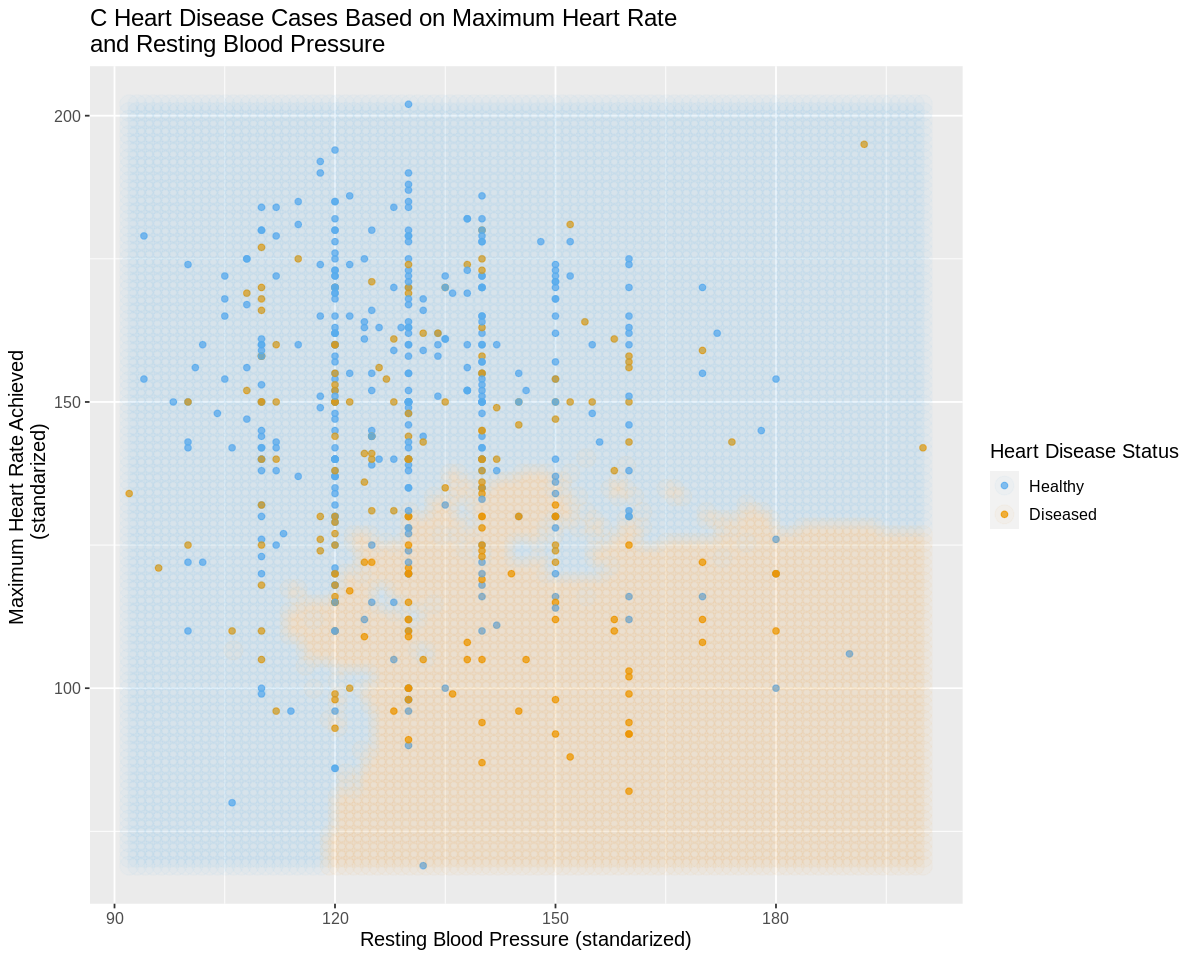

In [115]:
set.seed (123)
heart_data_3 <- data_heart |>
    select(RestingBP, MaxHR, HeartDisease) 


knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 46) |>
        set_engine("kknn") |>
        set_mode("classification")

uc_recipe <- recipe(HeartDisease ~ RestingBP + MaxHR, data = heart_data_3) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit2 <- workflow() |>
  add_recipe(uc_recipe) |>
  add_model(knn_spec2) |>
  fit(data = heart_data_3)




rbp_grid <- seq(min(heart_data_3$RestingBP), 
                max(heart_data_3$RestingBP), 
                length.out = 100)

mhr_grid <- seq(min(heart_data_3$MaxHR), 
                max(heart_data_3$MaxHR), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(RestingBP = rbp_grid, 
                                MaxHR = mhr_grid))


knnPredGrid2 <- predict(knn_fit2, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid2, asgrid) |> 
  rename(HeartDisease = .pred_class)


wkflw_plot2 <-
  ggplot() +
  geom_point(data = heart_data_3, 
             mapping = aes(x = RestingBP, 
                           y = MaxHR, 
                           color = HeartDisease), 
             alpha = 0.75) +

  geom_point(data = prediction_table, 
             mapping = aes(x = RestingBP, 
                           y = MaxHR, 
                           color = HeartDisease), 
             alpha = 0.03, size = 5) +

    labs(color = "Heart Disease Status", 
       x = "Resting Blood Pressure (standarized)", 
       y = "Maximum Heart Rate Achieved \n (standarized)") +
    ggtitle("C Heart Disease Cases Based on Maximum Heart Rate \nand Resting Blood Pressure") +
    scale_color_manual(labels = c("Healthy","Diseased"), 
                     values = c("steelblue2","orange2")) +
  theme(text = element_text(size = 12))
wkflw_plot2

Figure 4. The distribution of the model predictions for “heart disease” based on "Resting Blood Pressure" and "Maximum Heart Rate Achieved" where the background color indicates the decision of the classifier. 

Figure 4 demonstrates a colored prediction map visualization. This scatter plot of "Resting Blood Pressure" versus "Maximum Heart Rate Achieved" colored by "Heart Disease Status", visualizes the model predictions for the state of heart disease (‘healthy’ and ‘heart-disease’) based on the two predictors of "Resting Blood Pressure" and "Maximum Heart Rate". The figure predicts the heart disease status of the new observations considering where they will be located on the graph based on “Resting Blood Pressure" and "Maximum Heart Rate”. If the new observation is in the yellow area, the observation has heart disease, and if in the blue area, the observation shows a healthy state. The points on the graph are the actual observations with their heart disease status, which were used to develop the model. The figure also indicates that people with high blood pressure (>120) and low maximum heart rate (<150) are at a higher risk of heart disease in the population, based on the model’s prediction.

## Discussion:
By developing this model, we expected to be able to predict heart disease, with a reasonable accuracy for application in healthcare, based on the biological determinants and symptoms observed in individuals. 

The accuracy of the model was found to be ~69%. This accuracy is not significantly greater than the dominant class (normal, 66%). Therefore, the model is not a good predactor. In addition, a model with an accuracy of 69% is not applicable in healthcare system for making decisions about a crucial condition like heart disease.
Our model can lay the groundwork for designing a potential diagnostic tool assisting healthcare professionals to address life threatening heart diseases earlier and more accurately; although, the current model is far from that point now. 

Also, in our analysis, some relationships may be observed between heart disease and the predictors.
These observations can lead the researchers to answer further questions like what the physiological
mechanisms behind these relationships are. This model can be expanded by designing a model capable of predicting heart disease in individuals considering different types of chest pains and across different genders, which are the limitations of the current model.

## Refrences
1.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

2.Centers for Disease Control and Prevention, National Center for Health Statistics. About Multiple Cause of Death, 1999–2020. CDC WONDER Online Database website. Atlanta, GA: Centers for Disease Control and Prevention; 2022. Accessed February 21, 2022.

3.fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.
